## Install and Imports

In [155]:
!pip install gdown imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
import os
import cv2
import tensorflow as tf
import gdown #get data from GDrive
import numpy as np
import matplotlib.pyplot as plt
import imageio #render post processed output a lot better (better while working w/ videos)
from typing import List #List type annotations

In [157]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [158]:
#prevents machine from sucking up all memory and get out of memory errors
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

## Build Data Loading Functions:

The dataset used is an extract of the original Grid Corpus dataset. Had specific videos/ part of the dataset (i.e. only taken videos and transcripts from a single speaker, the original dataset has around 34 speakers) loaded into gdrive, would import the dataset from there.

The Grid Corpus is a large multitalker audiovisual sentence corpus designed to support joint computational-behavioral studies in speech perception. In brief, the corpus consists of high-quality audio and video (facial) recordings of 1000 sentences spoken by each of 34 talkers (18 male, 16 female), for a total of 34000 sentences. Sentences are of the form "put red at G9 now".

*More about the original dataset: [Grid Corpus](https://zenodo.org/record/3625687#.ZFvXhXZBxEY)*

In [159]:
url= "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 63.0MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [160]:
def load_video(path:str) -> List[float]: #takes path of video and outputs a string of floats

    cap = cv2.VideoCapture(path) #create cv2 instance
    #loop through each one of these and store the extracted frames in an array
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #only takes the cropped lip part of each frame (static slicing)
        #An advanced way is to use Dlib as used in the original LipNet paper.
    cap.release()

    #scaling each frame
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [161]:
#creating vocab- every single character that is expected to be encountered in our annotations
vocab= [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [162]:
#originally from the keras ctc Automatic Speech Recognition tutorial paper
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") #converts char to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary= char_to_num.get_vocabulary(), oov_token="", invert=True) #converts num to char


print(
    f"the vocabulary is : {char_to_num.get_vocabulary()}\n"
    f"size is : {char_to_num.vocabulary_size()}"
)

the vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
size is : 40


In [163]:
#load up our alignments
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [164]:
#returning the preprocessed videos and preprocessed alignments together from their respective paths

def load_data(path:str):
  path = bytes.decode(path.numpy())
  filename = path.split('/')[-1].split('.')[0] #colab
  #file_name = path.split('\\')[-1].split('.')[0]  for windows.
  video_path = os.path.join('data','s1',f'{filename}.mpg')
  alignment_path = os.path.join('data','alignments','s1',f'{filename}.align')
  frames=load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

In [165]:
test_path = '/data/s1/bbal6n.mpg'

In [166]:
#filename
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/data/s1/bbal6n'

In [167]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

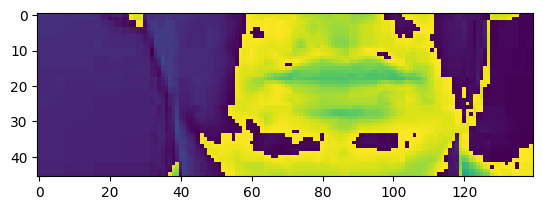

In [168]:
plt.imshow(frames[0])

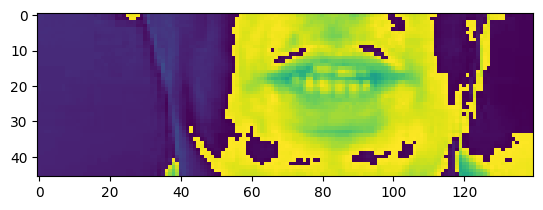

In [169]:
plt.imshow(frames[40])

In [170]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [171]:
tf.strings.reduce_join([num_to_char(word) for word in alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [172]:
def mappable_function(path:str)->List[str]:
  result=tf.py_function(load_data, [path], (tf.float32,tf.int64))
  return result

## Creating Data Pipeline:

Creating our data pipeline:

STEPS:

1. using tensorflow data pipeline we iterate thrugh our videos path.
2. shuffle to get a random video path everytime 
3. map the video to its alignments
4. add padding to the alignments (length=40) and take 75 frames for each video (we dont pad each frame/image). Take 2 sets of videos & alignments in one batch.
5. prefetching in order to optimize our pipileine to ensure we are loading and preloading while our model is training.

Cool.

In [173]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#Added for split
train= data.take(450)
test= data.skip(450)

In [174]:
len(train)

450

In [175]:
len(test)

50

In [176]:
#testing each code line in data pipeline:
#frames,aligns = data.as_numpy_iterator().next()

In [177]:
#len(frames) #2 set of frmes in each batch.

In [178]:
#plt.imshow(frames[0][29]) 29th frame of first video

In [179]:
#aligns[0] #first video alignment with padding.

In [180]:
test1= data.as_numpy_iterator()

In [181]:
val= test1.next(); val[0]

array([[[[[1.4348304 ],
          [1.5103477 ],
          [1.5103477 ],
          ...,
          [0.41534564],
          [0.41534564],
          [0.41534564]],

         [[1.4348304 ],
          [1.5481064 ],
          [1.5103477 ],
          ...,
          [0.45310432],
          [0.41534564],
          [0.41534564]],

         [[1.5103477 ],
          [1.5103477 ],
          [1.472589  ],
          ...,
          [0.37758693],
          [0.30206954],
          [0.30206954]],

         ...,

         [[1.0194848 ],
          [1.0194848 ],
          [1.0194848 ],
          ...,
          [0.07551739],
          [0.07551739],
          [0.07551739]],

         [[1.0194848 ],
          [1.0194848 ],
          [1.0194848 ],
          ...,
          [0.07551739],
          [0.07551739],
          [0.07551739]],

         [[1.0194848 ],
          [1.0194848 ],
          [1.0194848 ],
          ...,
          [0.07551739],
          [0.07551739],
          [0.03775869]]],


        [[[1.3970

In [182]:
imageio.mimsave('animation.gif',val[0][0],fps=10) 
#Cool function alert! This converts the first video instance out of the 2 in the batch to a gif of 10 fps.

So basically the gif created is what the model trains on along with the alignemnts to perform lip reading.

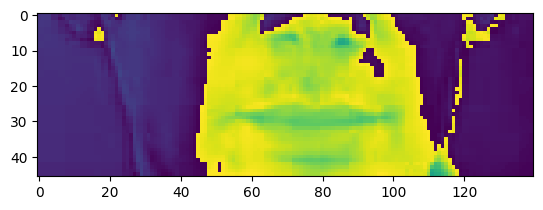

In [183]:
# 0/1: videos/alignments, 0/1: first or second video, 0-74: frames of video 1.
plt.imshow(val[0][0][0])

In [184]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white by x nine soon'>

In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv3D,LSTM, Dropout,Bidirectional, Activation, SpatialDropout3D, BatchNormalization, MaxPool3D,Reshape, Flatten,TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [186]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [187]:
char_to_num.vocabulary_size()

40

In [188]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [189]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_9 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_10 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [190]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [191]:
yhat[0].shape

(75, 41)

In [192]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'999944444444444444444443333344444444444444444444444444444444444444444444444'>

In [193]:
model.input_shape

(None, 75, 46, 140, 1)

In [194]:
model.output_shape

(None, 75, 41)

## Setting Up Training Options and Train

In [195]:
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

In [196]:
#CTC LOSS - this block of code has been picked up from Automatic Speech Recognition using CTC paper.
def CTCLoss(y_true,y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
  input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
  label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

  input_length=input_length* tf.ones(shape=(batch_len,1),dtype='int64')
  label_length = label_length* tf.ones(shape=(batch_len,1), dtype='int64')

  loss = tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length, label_length)
  return loss

In [197]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [198]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),loss =CTCLoss)

In [199]:
checkpoint_callback= ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss', save_weights_only=True)
                                     

In [200]:
schedule_callback = LearningRateScheduler(scheduler)

In [201]:
example_callback = ProduceExample(data)

In [202]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback], )

Epoch 1/100
1/1 [==============================] - 2s 2s/step
Original: lay green at z seven soon
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue at q six please
Prediction: le e e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 709s 2s/step - loss: 85.4129 - val_loss: 71.2436 - lr: 1.0000e-04
Epoch 2/100
171/450 [==========>...................] - ETA: 4:23 - loss: 73.5683

KeyboardInterrupt: ignored

as we reach 50+ epochs we see the model working out some comparable predictions.

## Making Predictions

Training for a 100 epochs takes alot of time. So i downloaded the model checkpoints available after 96 epochs of the above model training.

In [203]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 125MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [204]:
model.load_weights('models/checkpoint')

In [205]:
sample = test.as_numpy_iterator().next()

In [206]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 263ms/step


In [207]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in d three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red at o zero please'>]

In [208]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in d three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red at z zero please'>]

Our predictions seem to be near perfect and the model seems to be performing nicely.

## TEST ON A VIDEO

In [214]:
sample= load_data(tf.convert_to_tensor('/content/data/s1/briz8p.mpg'))

In [215]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red in z eight please'>]

In [216]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 166ms/step


In [217]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [218]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red in z eight please'>]

nice predictions. good results.